<a href="https://colab.research.google.com/github/liorhirsch/Kaggle-Landmark-ML-Challange/blob/master/Custom%20NN/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuring the environment either to local or remote usage

In [0]:
BASE_PATH='drive/My Drive'
# BASE_PATH="E:/Projects/ML_Project/Landmark_Kaggle_Challange"
MODEL_NAME = "1.0"

# TRAINING_DATA_DIR = BASE_PATH + '/photos'
# VALIDATION_DATA_DIR = BASE_PATH + '/validation'
TEST_DATA_PATH = BASE_PATH + '/test'

TRAINING_DATA_DIR = BASE_PATH + '/smallDS'
VALIDATION_DATA_DIR = BASE_PATH + '/smallDS'


MODEL_ENDING = ".H5"

RESULTS_PATH=BASE_PATH + "/results/"
SAVING_DIR_PATH=BASE_PATH + "/models/"
FULL_SAVING_PATH = SAVING_DIR_PATH + MODEL_NAME + MODEL_ENDING

# Upload data from google drive

In [110]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Build training data


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from joblib import Parallel, delayed
import multiprocessing

**Augmentated Data Generation**

Creates images generators both for the test and the training data, to create additional data

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen=ImageDataGenerator(
                              rotation_range=0,
                              width_shift_range=0,
                               height_shift_range=0,
                               shear_range=0,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies


 Uses the data as a stream object to enable batching on it instead of loading them all together to the ram using the ImageDataGenerator

In [114]:
image_size = (128,128)
batch_size = 20

train_generator=train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        VALIDATION_DATA_DIR,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 3328 images belonging to 100 classes.
Found 3328 images belonging to 100 classes.


# Validate the data

In [132]:
x_batch, y_batch = next(train_generator)
# print(x_batch) # RGB 2d array
print(x_batch[1:].shape)
print(y_batch[1:].shape)
# print(y_batch) # The label (class)

(19, 128, 128, 3)
(19, 100)


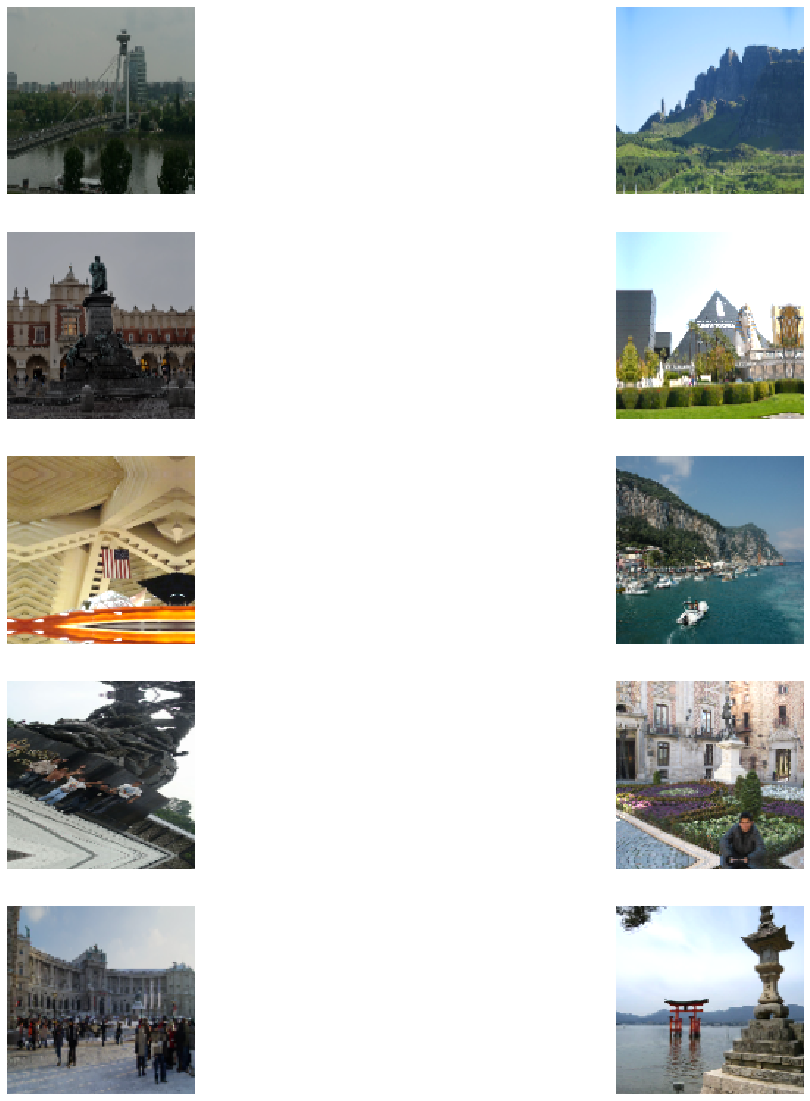

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(np.uint8)
    plt.imshow(image)

# Build The Model

In [0]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [0]:
!python -c 'import keras; import tensorflow; import sys; print("tensor : {}, keras: {}, python: {}".format(tensorflow.__version__, keras.__version__, sys.version))'

**Methods for specific package's versions installations**

In [0]:
# import pkg_resources
# pkg_resources.require("Twisted==8.2.0")
# import twisted

# To determine which version you're using:
# !pip show tensorflow

# For the current version: 
# !pip install --upgrade tensorflow
# !pip install tensorflow --upgrade --force-reinstall


# For a specific version:
# !pip install tensorflow==1.2

In [0]:
model = Sequential()
# model.add(Conv2D(64, (3,3), input_shape = x_batch.shape[1:]))
model.add(Conv2D(64, (3,3), input_shape = (image_size[0], image_size[1], 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(150))
model.add(Activation("relu"))

#output layer
model.add(Dense(100))
model.add(Activation('softmax'))

# Visualize the model

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
activation_20 (Activation)   (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
activation_21 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 28800)             0         
__________

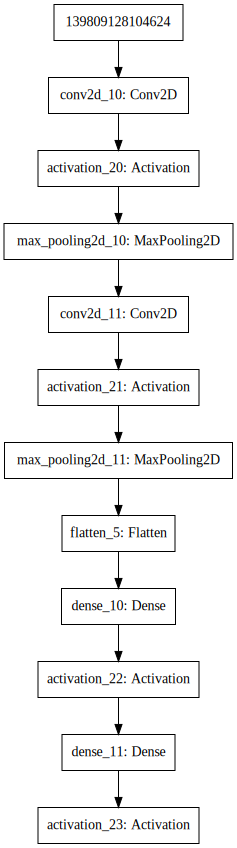

In [121]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train

Let us configure a loss function and optimizer.

The generator gives us in y a vector contains match percentages for each label, so we want to change it to show 0 or 1 using caregorical_crossentropy

In [0]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

we calculate the amount of batches in an ephoch (For fitting the model)

In [123]:
step_size_train=train_generator.n//train_generator.batch_size
print("step_size_train :", step_size_train)
step_size_validation=validation_generator.n//validation_generator.batch_size
print("step_size_validation :", step_size_validation)

step_size_train : 166
step_size_validation : 104


Fix for the error : 
OSError: image file is truncated (14 bytes not processed)

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

#https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

We define an early stopper to avoid wasting compute resources and time

In [0]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

In [0]:
class MultiGPUCheckpointCallback(Callback):

    def __init__(self, filepath, base_model, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        super(MultiGPUCheckpointCallback, self).__init__()
        self.base_model = base_model
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.base_model.save_weights(filepath, overwrite=True)
                        else:
                            self.base_model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('Epoch %05d: %s did not improve' %
                                  (epoch + 1, self.monitor))
            else:
                if self.verbose > 0:
                    print('Epoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.base_model.save_weights(filepath, overwrite=True)
                else:
                    self.base_model.save(filepath, overwrite=True)


In [0]:
import time

networkfileName = RESULTS_PATH + "/" + MODEL_NAME + "{}" + MODEL_ENDING.format(int(time.time()))

checkpoint = MultiGPUCheckpointCallback(filepath=networkfileName, base_model=model, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

Now we train the model with fit_generator instead of regular fit.

In [160]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=5,
                   callbacks = [early],
                   verbose=1)

Epoch 1/5
 49/166 [=======>......................] - ETA: 1:13 - loss: 15.8385 - acc: 0.0173

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


166/166 [==============================] - 204s 1s/step - loss: 15.8608 - acc: 0.0160 - val_loss: 15.8614 - val_acc: 0.0159
Epoch 2/5
166/166 [==============================] - 203s 1s/step - loss: 15.8584 - acc: 0.0161 - val_loss: 15.8614 - val_acc: 0.0159
Epoch 3/5
166/166 [==============================] - 199s 1s/step - loss: 15.8608 - acc: 0.0160 - val_loss: 15.8614 - val_acc: 0.0159
Epoch 00003: early stopping


# Examine the results

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

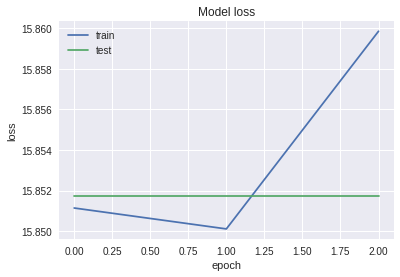

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model

Create results directory if it doesn't exist

In [0]:
import os
if not os.path.exists(SAVING_DIR_PATH):
    os.makedirs(SAVING_DIR_PATH)

In [0]:
model.save(FULL_SAVING_PATH)  # creates a HDF5 file 'my_model.h5'

# Load the model from h5 file

load the model from the saved file

In [0]:
from tensorflow.keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model(FULL_SAVING_PATH)

In [0]:
train_loss, train_acc = model.evaluate(X,y)

In [0]:
print("loss: ",train_loss, "acc: ",  train_acc)

# Test the model on the TestSet

Lets evaluate our model on the test set :


In [0]:
train_loss, train_acc = model.evaluate(x_batch,y)

In [0]:
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(TEST_DATA_PATH,
                                                  target_size=image_size,
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

step_size_test=test_generator.n//test_generator.batch_size

test_loss, test_acc = model_final.evaluate_generator(generator=test_generator, 
                               steps=step_size_test)
                               


In [0]:
print(train_loss)
print(train_acc)